# Lista 03

Artificial neural networks for image classification.

In [1]:
READ_DATASETS = False

## Common Functions

In [2]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Plotting

In [3]:
def create_image_panel(images, labels, cols=3, title=None):

    if len(images) != len(labels):
        raise ValueError("Number of images and labels must be equal.")

    rows = int(len(images) / cols) + (len(images) % cols > 0)
    fig, axes = plt.subplots(rows, cols, figsize=(5, rows * 2))

    for i in range(rows*cols):
        row, col = divmod(i, cols)
        if rows == 1:
            axs = axes[col]
        else:
            axs = axes[row, col]
        if i < len(images):
            axs.imshow(images[i])
            axs.set_title(labels[i])
        axs.axis('off')

    if title is not None:
        fig.suptitle(title, fontsize=12)
    plt.tight_layout()
    return fig

In [4]:
colors = [
    "#22223B",
    "#4A4E69",
    "#0B3954",
    "#087E8B",
    "#C81D25",
    "#FF5A5F",
    "#11270b",
    "#3c5a14",
]

In [5]:
def create_bar_plot(labels, values, axis_label=None, title=None,
                    values2=None, axis2_label=None,
                    horizontal=False):

    if len(values) != len(labels):
        raise ValueError("Number of values and labels must be equal.")
    if horizontal and values2 is not None:
        raise ValueError("Cannot have twin axis in a horizontal bar plot.")

    fig, ax1 = plt.subplots(figsize=(5, 3))

    color = colors[0]
    color2 = colors[1]
    if values2 is None:
        width = 0.8
        delta = 0.
    else:
        width = 0.4
        delta = width/2.

    if horizontal:
        ax1.barh(
            labels,
            values,
            color=color,
        )
    else:
        ax1.bar(
            np.arange(len(labels)) - delta,
            values,
            color=color,
            width=width,
            align="center",
        )

    if values2 is not None:
        ax2 = ax1.twinx()
        ax2.bar(
            np.arange(len(labels)) + delta,
            values2,
            color=color2,
            width=width,
            align="center",
        )

    if not horizontal:
        ax1.set_xticks(np.arange(len(labels)))
        ax1.set_xticklabels(labels, rotation=0) #, fontdict={'fontsize':9})
    if axis_label is not None:
        if horizontal:
            ax1.set_xlabel(axis_label, color=color)
        else:
            ax1.set_ylabel(axis_label, color=color)
    if axis2_label is not None:
        ax2.set_ylabel(axis2_label, color=color2)

    if title is not None:
        plt.title(title)
    plt.tight_layout()
    return fig

### Model History

In [6]:
def plot_metrics(history, metrics = ['acc', 'loss']):
    best = np.argmax(history['val_acc'])
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(
            range(len(history[metric])),
            history[metric],
            color=colors[2],
            label='Train')
        plt.plot(
            range(len(history[metric])),
            history['val_'+metric],
            color=colors[3],
            label='Val')
        plt.plot(best,
                 history['val_'+metric][best],
                 marker='o',
                 color='red')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()
        plt.tight_layout()

### Confusion Matrix

In [7]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

In [8]:
def print_table(data, horizontal_lines=[1]):
    column_widths = [max(len(str(item)) for item in column)
                     for column in zip(*data)]
    format_string = " | ".join(f"{{:<{width}}}" for width in column_widths)
    for i, row in enumerate(data):
        if i in horizontal_lines:
            print("-" * len("| " + format_string.format(*row) + " |"))
        print("| " + format_string.format(*row) + " |")

In [9]:
def model_summary(X_test, y_test, y_pred, labels, description, filename):

    def _model_summary_table(y_pred, y_test, labels):
        results = [("Class", "Accuracy", "Recall")]
        acc = accuracy_score(y_test, y_pred)
        balanced_accuracy = recall_score(y_test, y_pred, average="macro")
        results.append((
            "All",
            f"{acc:0.4f}",
            f"{balanced_accuracy:0.4f}"))
        recall = recall_score(y_test, y_pred, average=None)
        for i, (label, rec) in enumerate(zip(labels, recall)):
            acc = accuracy_score(y_test[y_test==i], y_pred[y_test==i])
            results.append((
                label,
                f"{acc:0.4f}",
                f"{rec:0.4f}"))
        print_table(results, horizontal_lines=[1, 2])


    def _model_summary_confusion_matrix(y_test, y_pred, labels, description, filename):
        conf_matrix = confusion_matrix(y_test, y_pred)
        conf_matrix_disp = ConfusionMatrixDisplay(
            confusion_matrix=conf_matrix, display_labels=labels
        )
        _, ax = plt.subplots(figsize=(8, 6))
        plt.title(f"{description} Confusion Matrix")
        conf_matrix_disp.plot(ax=ax, xticks_rotation=25)
        conf_matrix_disp.im_.set_clim(0, 600)
        plt.savefig(f"report/png/{filename}", bbox_inches="tight")
        plt.show()

    _model_summary_table(y_pred, y_test, labels)
    _model_summary_confusion_matrix(
        y_pred, y_test, labels, description, filename)

## Database

 https://medmnist.com/

In [10]:
from medmnist import BloodMNIST

image_size=28
if READ_DATASETS:
    train_dataset = BloodMNIST(split="train", download=True, size=image_size)
    val_dataset = BloodMNIST(split="val", download=True, size=image_size)
    test_dataset = BloodMNIST(split="test", download=True, size=image_size)

    _ = joblib.dump(train_dataset, f"data/train_dataset_{image_size}.sav")
    _ = joblib.dump(val_dataset, f"data/val_dataset_{image_size}.sav")
    _ = joblib.dump(test_dataset, f"data/test_dataset_{image_size}.sav")
else:
    train_dataset = joblib.load(f"data/train_dataset_{image_size}.sav")
    val_dataset = joblib.load(f"data/val_dataset_{image_size}.sav")
    test_dataset = joblib.load(f"data/test_dataset_{image_size}.sav")

In [11]:
train_dataset

Dataset BloodMNIST of size 28 (bloodmnist)
    Number of datapoints: 11959
    Root location: C:\Users\tiago.LENOVO-I7\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28

In [12]:
labels = [
    'basophil',
    'eosinophil',
    'erythroblast',
    'immature granulocytes',
    'lymphocyte',
    'monocyte',
    'neutrophil',
    'platelet'
]

In [13]:
X_train = train_dataset.imgs[:] / 255.
y_train = train_dataset.labels[:,0]

X_val = val_dataset.imgs[:] / 255.
y_val = val_dataset.labels[:,0]

X_test = test_dataset.imgs[:] / 255.
y_test = test_dataset.labels[:,0]

In [14]:
print(f"Train data: {X_train.shape}")
print(f"Validation data: {X_val.shape}")
print(f"Test data: {X_test.shape}")

Train data: (11959, 28, 28, 3)
Validation data: (1712, 28, 28, 3)
Test data: (3421, 28, 28, 3)


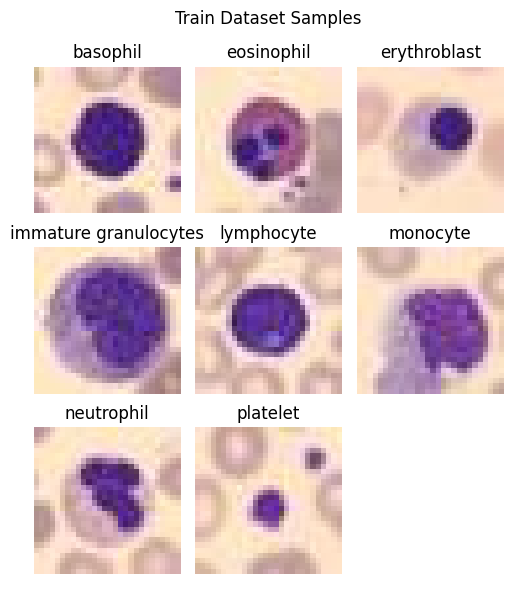

In [15]:
images = []
for i in range(len(labels)):
    images.append(X_train[y_train==i][0])

image_panel = create_image_panel(images, labels, title="Train Dataset Samples")
plt.show(image_panel)

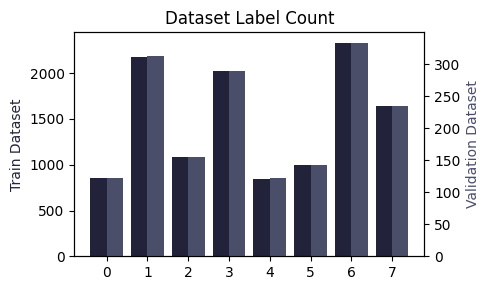

In [16]:
label_count_train = [sum(y_train==i) for i in range(len(labels))]
label_count_val = [sum(y_val==i) for i in range(len(labels))]
create_bar_plot(
    labels=range(len(labels)),
    values=label_count_train,
    axis_label="Train Dataset",
    values2=label_count_val,
    axis2_label="Validation Dataset",
    title="Dataset Label Count",
)
plt.show()

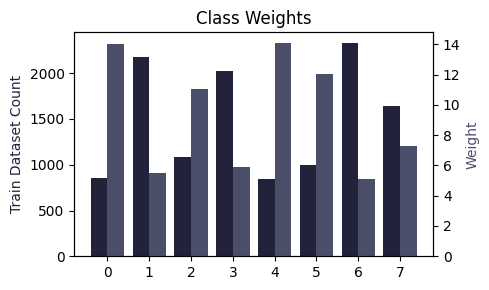

In [17]:
class_weight = {i:1 / sum(y_train==i) * len(y_train) for i in range(len(labels))}

create_bar_plot(
    labels=range(len(labels)),
    values=label_count_train,
    axis_label="Train Dataset Count",
    values2=class_weight.values(),
    axis2_label="Weight",
    title="Class Weights",
)
plt.show()

## MLP

In [18]:
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [19]:
def make_mlp(neurons=100, optimizer="rmsprop", activation="relu", use_augmentation=False):

    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(shape=(image_size,image_size,3)))

    if use_augmentation:
        model.add(keras.layers.RandomFlip("horizontal_and_vertical"))
        model.add(keras.layers.RandomRotation(0.2))

    model.add(keras.layers.Flatten(name="Flatten"))
    model.add(keras.layers.Dense(neurons, activation=activation, name="Dense"))
    model.add(keras.layers.Dense(len(labels), activation="softmax", name="Output"))

    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(),
        optimizer=optimizer,
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")])

    return model

In [20]:
def plot_model(model, name):
    name = f'./report/png/{name}.png'
    return keras.utils.plot_model(
        model=model,
        to_file=name,
        show_shapes=True,
        dpi=75,
        show_layer_activations=True)

In [21]:
def save_model(name, model):
    _ = joblib.dump(model, f"models/{name}.sav")
    model.model().save(f"models/{name}.keras")

def load_model(name, keras_model=False):
    if keras_model:
        model = keras.models.load_model(f"models/{name}.keras")
    else:
        model = joblib.load(f"models/{name}.sav")
    return model

In [22]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_acc",
        patience=10,
        start_from_epoch=10,
        mode='max',
        restore_best_weights=True
    ),
]

In [23]:
mlp_params = {
    'neurons': [2**i for i in range(6,11)],
    'optimizer': ['SGD', 'RMSprop', 'Adam'],
    'activation': ['relu', 'tanh'],
    'use_augmentation': [False, True],
    'batch_size': [2**i for i in range(4,8)],
    'class_weight':[None, class_weight]
}
mlp_params

{'neurons': [64, 128, 256, 512, 1024],
 'optimizer': ['SGD', 'RMSprop', 'Adam'],
 'activation': ['relu', 'tanh'],
 'use_augmentation': [False, True],
 'batch_size': [16, 32, 64, 128],
 'class_weight': [None,
  {0: 14.036384976525822,
   1: 5.4832645575424115,
   2: 11.022119815668203,
   3: 5.902764067127344,
   4: 14.085983510011777,
   5: 12.04330312185297,
   6: 5.132618025751072,
   7: 7.278758368837493}]}

In [24]:
combinations = np.prod([len(i) for i in mlp_params.values()])
print(f"Number of possible combinations: {combinations}")

Number of possible combinations: 480


In [25]:
def print_grid_cv_results(cv_results):
    results = [('#','Accuracy', '', 'Parameters'),
            ('','Mean', 'StdDev','')]
    results.append(('Best',
                    f"{cv_results.best_score_:0.4f}",
                    '',
                    f"{cv_results.best_params_}"))
    means = cv_results.cv_results_['mean_test_score']
    stds = cv_results.cv_results_['std_test_score']
    params = cv_results.cv_results_['params']
    for i, (mean, stdev, param) in enumerate(zip(means, stds, params)):
        results.append((
            i,
            f"{mean:0.4f}",
            f"{stdev:0.4f}",
            f"{param}",
        ))
    print_table(results,[2,3])

    return {'param': params,
            'mean': means,
            'std_dev': stds}

In [26]:
best_params = {
    'neurons': 128,
    'optimizer': 'SGD',
    'activation': 'relu',
    'use_augmentation': False,
    'batch_size': 32,
    'class_weight':None
}

samples_pc = 0.4
n_train = int(len(y_train) * samples_pc)
n_val = int(len(y_val) * samples_pc)
grid_results = {}

In [27]:
def do_grid_search(tests):
    new_params = {k: mlp_params[k] for k in tests}

    new_model = KerasClassifier(
        model=make_mlp,
        neurons=best_params['neurons'],
        activation=best_params['activation'],
        optimizer=best_params['optimizer'],
        use_augmentation=best_params['use_augmentation'],
        batch_size=best_params['batch_size'],
        class_weight=best_params['class_weight'],
        callbacks=callbacks)

    grid_search = GridSearchCV(new_model, new_params, cv=StratifiedKFold(3))
    grid_search_results = grid_search.fit(
        X_train[:n_train], y_train[:n_train], epochs=50,
        validation_data=(X_val[:n_val], y_val[:n_val]),
        callbacks=callbacks)

    grid_results[tests] = print_grid_cv_results(grid_search_results)
    for k in tests:
        best_params[k] = grid_search.best_params_[k]

In [32]:
tests = ('use_augmentation', 'class_weight')
do_grid_search(tests)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.2129 - loss: 3.2726 - val_acc: 0.5234 - val_loss: 1.5810
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.3854 - loss: 1.6556 - val_acc: 0.3904 - val_loss: 1.4375
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.4684 - loss: 1.3585 - val_acc: 0.5965 - val_loss: 1.1207
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.5285 - loss: 1.2419 - val_acc: 0.5585 - val_loss: 1.1018
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.5788 - loss: 1.1371 - val_acc: 0.6023 - val_loss: 1.0730
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.5896 - loss: 1.1008 - val_acc: 0.6287 - val_loss: 1.0129
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.6011 - loss: 1.0971 - val_acc: 0.6360 - val_loss: 0.9793
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.6357 - loss: 1.0266 - val_acc: 0.6564 - val_loss: 0.9308
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - ac

In [29]:
best_params

{'neurons': 128,
 'optimizer': 'SGD',
 'activation': 'relu',
 'use_augmentation': True,
 'batch_size': 32,
 'class_weight': None}

In [35]:
tests = ('neurons',)
do_grid_search(tests)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - acc: 0.1833 - loss: 2.6830 - val_acc: 0.3246 - val_loss: 1.7672
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - acc: 0.3548 - loss: 1.6850 - val_acc: 0.3567 - val_loss: 1.4275
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - acc: 0.4090 - loss: 1.4806 - val_acc: 0.6170 - val_loss: 1.2656
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - acc: 0.4672 - loss: 1.3566 - val_acc: 0.6374 - val_loss: 1.1449
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - acc: 0.5235 - loss: 1.2391 - val_acc: 0.6594 - val_loss: 1.0561
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - acc: 0.5507 - loss: 1.1898 - val_acc: 0.6857 - val_loss: 0.9769
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - acc: 0.5876 - loss: 1.1076 - val_acc: 0.4971 - val_loss: 1.1970
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.5906 - loss: 1.1072 - val_acc: 0.5775 - val_loss: 1.0363
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/

In [56]:
best_params

{'neurons': 128,
 'optimizer': 'SGD',
 'activation': 'relu',
 'use_augmentation': True,
 'batch_size': 32,
 'class_weight': None}

In [50]:
tests = ('optimizer', 'activation', 'batch_size')
do_grid_search(tests)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - acc: 0.2597 - loss: 2.3769 - val_acc: 0.4708 - val_loss: 1.4915
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.4456 - loss: 1.4656 - val_acc: 0.3085 - val_loss: 1.7256
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - acc: 0.5220 - loss: 1.3015 - val_acc: 0.3874 - val_loss: 1.6168
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.5545 - loss: 1.2009 - val_acc: 0.5906 - val_loss: 1.1147
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.6077 - loss: 1.1038 - val_acc: 0.5599 - val_loss: 1.0935
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - acc: 0.5971 - loss: 1.1062 - val_acc: 0.5906 - val_loss: 1.0780
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.6350 - loss: 1.0404 - val_acc: 0.5950 - val_loss: 0.9916
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.6154 - loss: 1.0568 - val_acc: 0.6213 - val_loss: 0.9317
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - ac

In [51]:
best_params

{'neurons': 128,
 'optimizer': 'SGD',
 'activation': 'relu',
 'use_augmentation': True,
 'batch_size': 16,
 'class_weight': None}

#### Results

In [28]:
best_params = {
    'neurons': 128,
    'optimizer': 'SGD',
    'activation': 'relu',
    'use_augmentation': True,
    'batch_size': 16,
    'class_weight':None
}

In [29]:
grid_results[('neurons',)] = {'param': 0,
            'mean': [0.6153, 0.7548, 0.7439, 0.7330, 0.7259],
            'std_dev': [0.1219, 0.0311, 0.0290, 0.0417, 0.0192]}

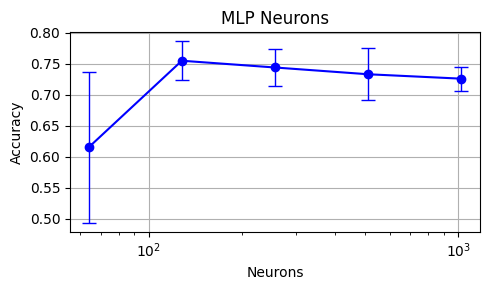

In [30]:
fig = plt.figure(figsize=(5,3))
plt.errorbar(mlp_params['neurons'],
            grid_results[('neurons',)]['mean'],
            fmt='b-', marker='o',
            yerr=grid_results[('neurons',)]['std_dev'],
            capsize=5, elinewidth=1)
plt.xlabel('Neurons')
plt.ylabel('Accuracy')
plt.title('MLP Neurons')
plt.xscale('log')
plt.grid()
plt.tight_layout()
plt.savefig('report/png/MLP_neurons.png')
plt.show()

In [31]:
best_params

{'neurons': 128,
 'optimizer': 'SGD',
 'activation': 'relu',
 'use_augmentation': True,
 'batch_size': 16,
 'class_weight': None}

In [32]:
callbacks_final = [
    keras.callbacks.EarlyStopping(
        monitor="val_acc",
        patience=20,
        start_from_epoch=30,
        mode='max',
        restore_best_weights=True
    ),
]

mlp = KerasClassifier(
    model=make_mlp,
    callbacks=callbacks_final,
    **best_params)

history_ = mlp.fit(
    X_train, y_train,epochs=200,
    validation_data=(X_val, y_val))

Epoch 1/200
748/748 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - acc: 0.3824 - loss: 1.8029 - val_acc: 0.5736 - val_loss: 1.0898
Epoch 2/200
748/748 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - acc: 0.6201 - loss: 1.0511 - val_acc: 0.6104 - val_loss: 1.0090
Epoch 3/200
748/748 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - acc: 0.6521 - loss: 0.9574 - val_acc: 0.6799 - val_loss: 0.8434
Epoch 4/200
748/748 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - acc: 0.6629 - loss: 0.9353 - val_acc: 0.6466 - val_loss: 0.9412
Epoch 5/200
748/748 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - acc: 0.6877 - loss: 0.8754 - val_acc: 0.7225 - val_loss: 0.7536
Epoch 6/200
748/748 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - acc: 0.7004 - loss: 0.8418 - val_acc: 0.6735 - val_loss: 0.8482
Epoch 7/200
748/748 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - acc: 0.7071 - loss: 0.8185 - val_acc: 0.7132 - val_loss: 0.8146
Epoch 8/200
748/748 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - acc: 0.7088 - loss: 0.8106 - val_acc: 0.6706 - val_loss: 0.9588
Epoch 9/200
748/748 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms

In [33]:
y_pred = mlp.predict(X_test)

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


| Class                 | Accuracy | Recall |
---------------------------------------------
| All                   | 0.7992   | 0.7551 |
---------------------------------------------
| basophil              | 0.5205   | 0.5205 |
| eosinophil            | 0.9247   | 0.9247 |
| erythroblast          | 0.7878   | 0.7878 |
| immature granulocytes | 0.6615   | 0.6615 |
| lymphocyte            | 0.6749   | 0.6749 |
| monocyte              | 0.5599   | 0.5599 |
| neutrophil            | 0.9204   | 0.9204 |
| platelet              | 0.9915   | 0.9915 |


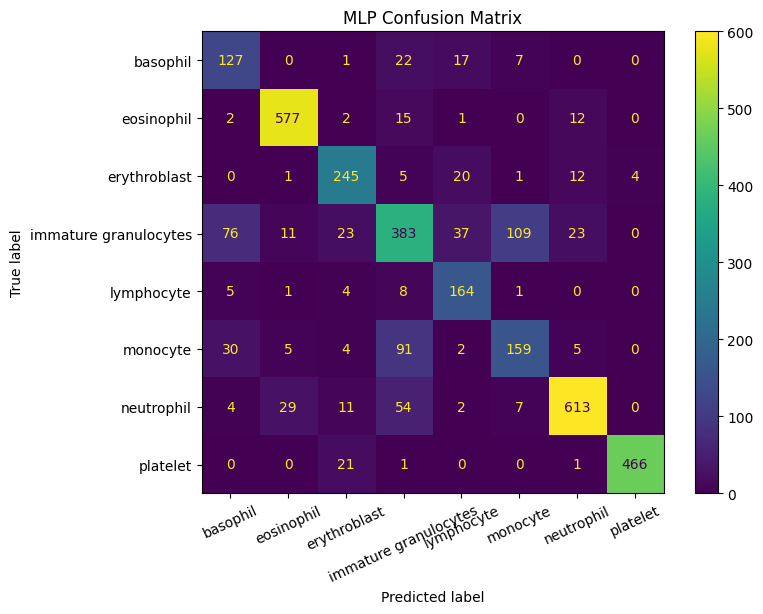

In [34]:
model_summary(X_test, y_test, y_pred, labels, "MLP", "MLP_CM")

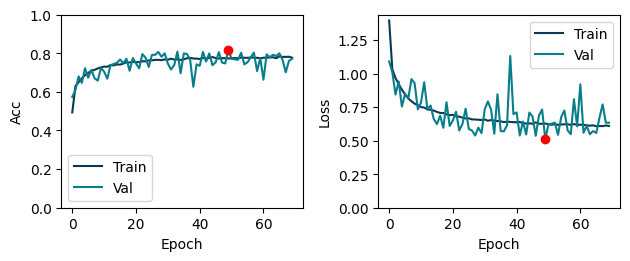

In [35]:
plot_metrics(history_.history_)
plt.savefig('./Report/png/MLP_history.png')
plt.show()

In [48]:
print(f"Epochs = {len(history_.history_['val_loss'])}")

Epochs = 70


In [36]:
best_params

{'neurons': 128,
 'optimizer': 'SGD',
 'activation': 'relu',
 'use_augmentation': True,
 'batch_size': 16,
 'class_weight': None}

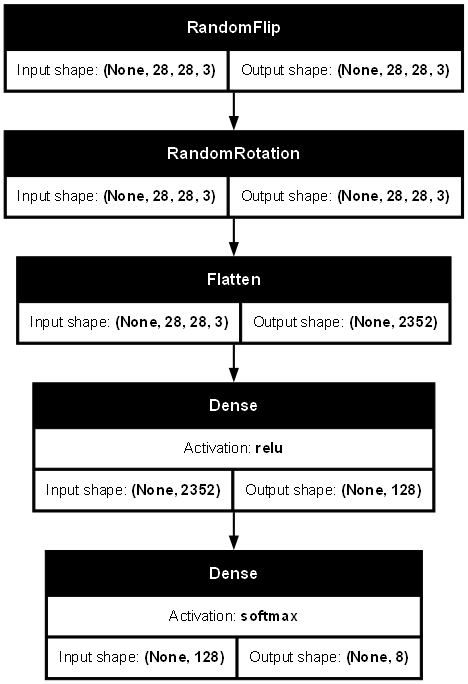

In [37]:
filtered_best_params = {k: best_params[k] for k in ("neurons",
                                                    "activation",
                                                    "use_augmentation",
                                                    "optimizer")}
mlp_for_plot = make_mlp(**filtered_best_params)
plot_model(model=mlp_for_plot, name='MLP_model')

In [38]:
mlp_for_plot.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)      │ (None, 28, 28, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 28, 28, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense (Dense)                   │ (None, 128)            │       301,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 302,216 (1.15 MB)

 Trainable params: 302,216 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
save_model(name="MLP", model=mlp)

In [40]:
def get_ranks(data):
    ranks = []
    for inner_list in data:
        sorted_list = sorted(inner_list, reverse=True)
        rank_dict = {val: i for i, val in enumerate(sorted_list)}
        ranks.append([rank_dict[val] for val in inner_list])
    return ranks

def rank_histogram(model, X_test, y_test):
    probas = model.predict_proba(X_test)
    all_ranks = get_ranks(probas)
    true_rank = [r[y] for (r,y) in zip(all_ranks,y_test)]
    rank_count = [true_rank.count(i) for i in range(len(labels))]
    rank_count_pc = [c/sum(rank_count)*100 for c in rank_count]
    create_bar_plot(labels=range(2,len(labels)+1),
                values=rank_count_pc[1:],
                axis_label="Frequency [%]",
                title=f"MLP: Rank of Failed Test Samples")

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


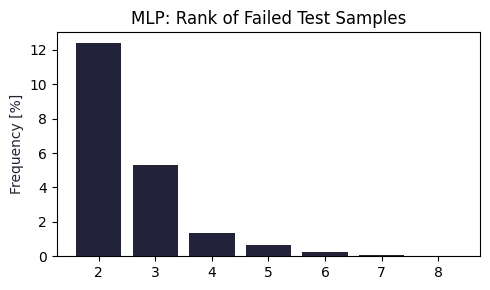

In [41]:
rank_histogram(mlp, X_test, y_test)
plt.savefig("./Report/png/MLP_rank.png")
plt.show()

In [42]:
def get_rank(y_prob, y_true):
    return len(y_prob) - sorted(y_prob).index(y_prob[y_true])

def get_results(model, x, y_true):
    y_prob = model.predict_proba([x])
    y_pred = list(y_prob).index(max(y_prob))

    return {
        'y_true': y_true,
        'y_pred': y_pred,
        'fail': y_pred!=y_true,
        'rank': get_rank(y_prob, y_true),
        'proba': y_prob,
        'delta_proba': y_prob[y_pred] - y_prob[y_true]
    }

In [43]:
def create_fail_panel(images, results, title=None):

    if len(images) != len(results):
        raise ValueError("Number of images and labels must be equal.")

    rows = len(images)
    fig, axes = plt.subplots(rows, 2, figsize=(5, rows * 2))

    for i, result in enumerate(results):
        ax0 = axes[i, 0]
        ax0.imshow(images[i])
        ax0.set_title(f'True class: {result["y_true"]}')
        ax0.axis('off')

        ax1 = axes[i, 1]
        ax1.bar(
            range(len(labels)),
            result['proba'])

        ax1.set_title(f'True rank: {result["rank"]}')
        ax1.set_xlabel('Class')
        ax1.set_ylabel('Probability')
        ax1.set_xticks(range(len(labels)))
        ax1.set_xticklabels(range(len(labels)), rotation=0)

    if title is not None:
        fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    return fig

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


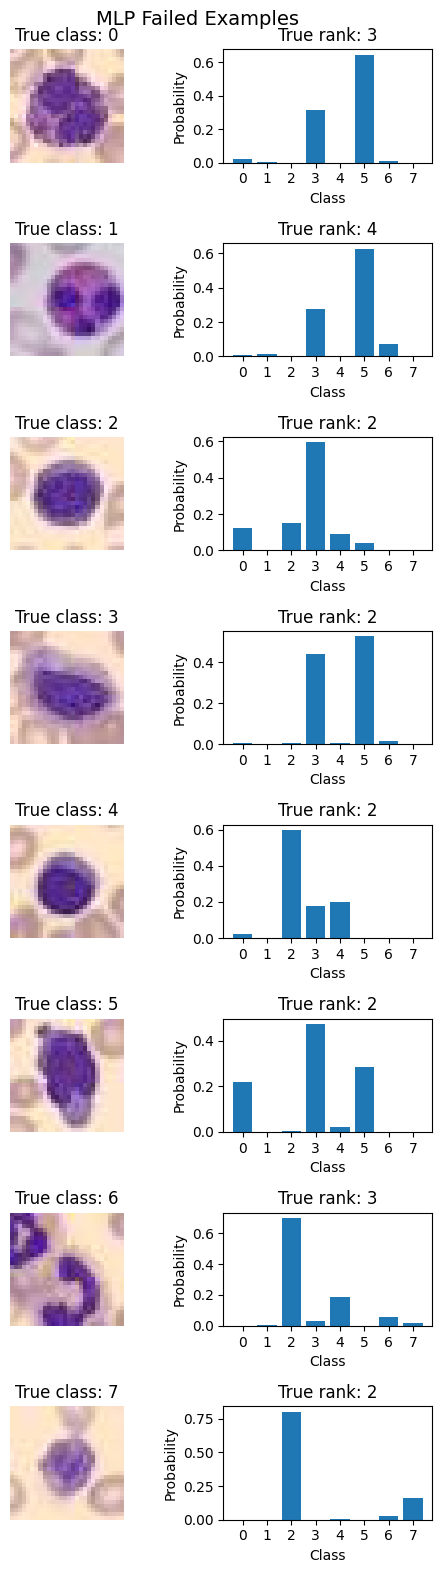

In [44]:
fail = y_pred != y_test

images = []
results = []
for i in range(len(labels)):
    if sum(y_test[fail]==i) > 0:
        x = X_test[fail][y_test[fail]==i][0]
        y_true = y_test[fail][y_test[fail]==i][0]

        results.append(get_results(
            model=mlp,
            x = x,
            y_true = y_true))
        images.append(x)

create_fail_panel(images=images, results=results, title="MLP Failed Examples")
plt.savefig('./Report/png/MLP_fails.png')
plt.show()